# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment iterations.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths. 
The last cell vizualizes 3 different reference images with very different D values. 

In [1]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 16    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 20000        # Diffusion coefficient in nm^2 per s (=0.000001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50
val_im_per_index = 5


In [2]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from modelsUtils import *
from simpleCNNModel import *
from ResNetModel2D import *
from ResNetModel3D import *
from paperCNN import *
from paperCNNNoPooling import *
import os.path

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Using device: cpu


In [3]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the list with the wanted train fct

lr = 0.000001
models_params = {
    #"simpleCNN": {"class": SimpleCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet2D": {"class": ResNet2D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet3D": {"class": ResNet3D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "ParkCNN": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    #"paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr},
    #"paperCNNNoPool": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" :lr}
}


In [4]:

for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])

Model weights loaded from w_resNet2D.pth
resNet2D Loaded existing weights
Model weights loaded from w_resNet3D.pth
resNet3D Loaded existing weights
Model weights loaded from w_ParkCNN.pth
ParkCNN Loaded existing weights


In [5]:
from torchsummary import summary
for name, params in models_params.items():
    print(name)
    model = params["loaded_model"]
    print(sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
)

resNet2D
4908993
resNet3D
3611841
ParkCNN
2160145


In [6]:
# run this cell to reset loss histories
totalEpochs = 0
tr_loss_histories = {name: [] for name in models_params.keys()}
val_loss_histories = {}

for name, params in models_params.items():

    filename = "l_" + name + ".npy"
    if os.path.exists(filename):
        val_loss_histories[name] = np.load(filename)
        print(name, "Loaded existing losses")
        totalEpochs = len(val_loss_histories[name])
    else:
        print(name, "Did not find losses, loaded an empty array")
        val_loss_histories[name] = np.array([])

ds = "allDs.npy"
if os.path.exists(ds):
    allGeneratedDs = np.load(ds)
else:
    allGeneratedDs = np.array([])   


resNet2D Loaded existing losses
resNet3D Loaded existing losses
ParkCNN Loaded existing losses


In [7]:
def average_predictions(predictions, group_size=5):
    """
    Averages predictions in groups of `group_size`.

    Parameters:
    - predictions (torch.Tensor): Input tensor of shape (n * group_size,).
    - group_size (int): The number of elements to average in each group. Default is 5.

    Returns:
    - torch.Tensor: Tensor of shape (n,) where each element is the average of a group of `group_size` elements.
    """
    if predictions.numel() % group_size != 0:
        raise ValueError(f"The input tensor size {predictions.numel()} must be divisible by the group size {group_size}.")
    
    # Reshape to group elements for averaging
    grouped = predictions.view(-1, group_size)
    # Compute the mean along the group dimension
    averaged = grouped.mean(dim=1)
    return averaged

# load validation images
val_trajs = np.load('validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, val_im_per_index, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
print(val_images.shape)
valDs = torch.tensor(valDs/1000, dtype=torch.float32, device=device)
valDsGrouped =  average_predictions(valDs)
valDs_array = valDsGrouped.view(-1).cpu().numpy()  # Convert to numpy for plotting



(250, 16, 64, 64)


In [68]:
epochs = 20
N = 128 # Number of samples per iteration
verbose = False # print in console
for i in range(epochs):

    print(f"Generating images for iteration: {i}")

    images, estimatedDs =  generateImagesAndEstimateDMAXD(N, nframes, npixel, factor_hr, nposframe, 30000, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
    
    # Divide the estimateDs by 10000 to get values in the range 0.5->70, then add them to the list of all Ds
    estimatedDs = estimatedDs / 1000
    allGeneratedDs = np.append(allGeneratedDs,estimatedDs)
    

    # Add channel dimension to images: (N, 16, 64, 64) -> (N, 16, 1, 64, 64)
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
    estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)


    for name, params in models_params.items():
        model = params["loaded_model"]
        train_fct = params["train_fct"]
        criterion = params["criterion"]
        optimizer = params["optimizer"]
        if(verbose):
            print("Training model:" , name)
        trained_model, tr_loss_history = train_fct(model, images, estimatedDs, device, criterion, optimizer, epochs=1, batch_size=16)
        params["loaded_model"] = trained_model

        # Compute validation loss on fixed set of images
        model_preds = predict_diffusion_coefficients(trained_model, val_images ,device)
        if(name == 'paperCNNSGD'):
            print(model_preds)
        loss = criterion(model_preds, valDs)
        val_loss_histories[name] = np.append(val_loss_histories[name],loss.item())



        # Store the single training epoch loss
        if isinstance(tr_loss_history, list) and len(tr_loss_history) > 0:
            tr_loss_histories[name].append(tr_loss_history[-1])  # Append last loss in the history
        elif isinstance(tr_loss_history, (float, int)):  # If it's a single loss value
            tr_loss_histories[name].append(tr_loss_history)
        else:
            print(f"Unexpected loss format for model {name}: {tr_loss_history}")

# add up epochs for later use 
totalEpochs = totalEpochs + epochs



Generating images for iteration: 0


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.56it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:36<00:00,  3.54it/s]


Generating images for iteration: 1


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 21.38it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.61it/s]


Generating images for iteration: 2


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.20it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:37<00:00,  3.43it/s]


Generating images for iteration: 3


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 23.56it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:37<00:00,  3.43it/s]


Generating images for iteration: 4


Generating trajectories: 100%|██████████| 128/128 [00:04<00:00, 25.65it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:34<00:00,  3.74it/s]


Generating images for iteration: 5


Generating trajectories: 100%|██████████| 128/128 [00:07<00:00, 18.21it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:34<00:00,  3.66it/s]


Generating images for iteration: 6


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.06it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:36<00:00,  3.51it/s]


Generating images for iteration: 7


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.55it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.62it/s]


Generating images for iteration: 8


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.43it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.66it/s]


Generating images for iteration: 9


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 23.72it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:37<00:00,  3.44it/s]


Generating images for iteration: 10


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 23.86it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:37<00:00,  3.44it/s]


Generating images for iteration: 11


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.60it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.57it/s]


Generating images for iteration: 12


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 24.34it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.65it/s]


Generating images for iteration: 13


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 23.25it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:34<00:00,  3.66it/s]


Generating images for iteration: 14


Generating trajectories: 100%|██████████| 128/128 [00:06<00:00, 20.95it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:36<00:00,  3.55it/s]


Generating images for iteration: 15


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 23.95it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.65it/s]


Generating images for iteration: 16


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 23.25it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:36<00:00,  3.51it/s]


Generating images for iteration: 17


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 22.65it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:35<00:00,  3.60it/s]


Generating images for iteration: 18


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 21.40it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:36<00:00,  3.48it/s]


Generating images for iteration: 19


Generating trajectories: 100%|██████████| 128/128 [00:05<00:00, 21.75it/s]


running program on each 8 cpu core of the computer


Generating images and estimating D: 100%|██████████| 128/128 [00:34<00:00,  3.67it/s]


1.1442691862332344
20.039715252882203
200.8046772627592
73600


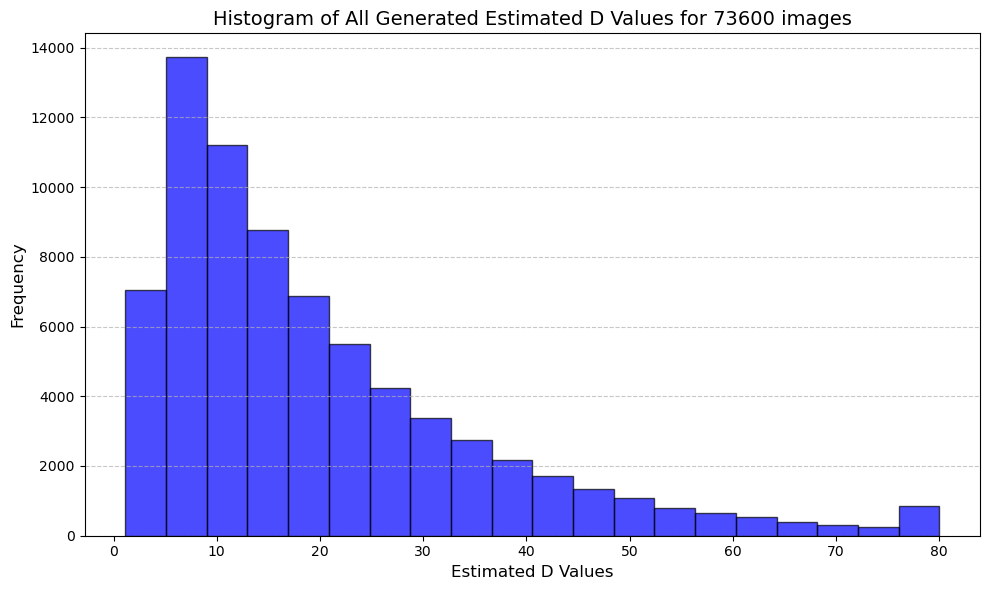

In [8]:

print(np.min(allGeneratedDs))
print(np.mean(allGeneratedDs))
print(np.max(allGeneratedDs))
print(len(allGeneratedDs))
nbrDs = len(allGeneratedDs)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(np.clip(allGeneratedDs,0,80), bins=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Estimated D Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Histogram of All Generated Estimated D Values for {nbrDs} images', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()

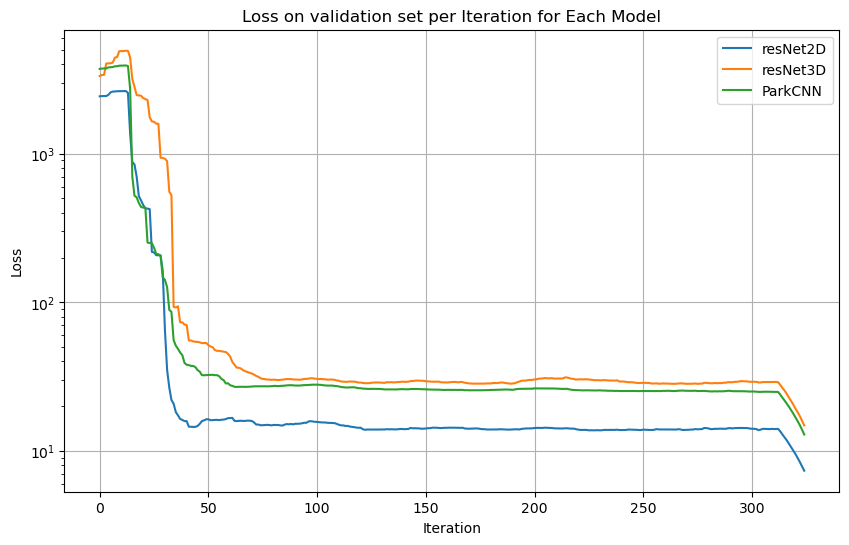

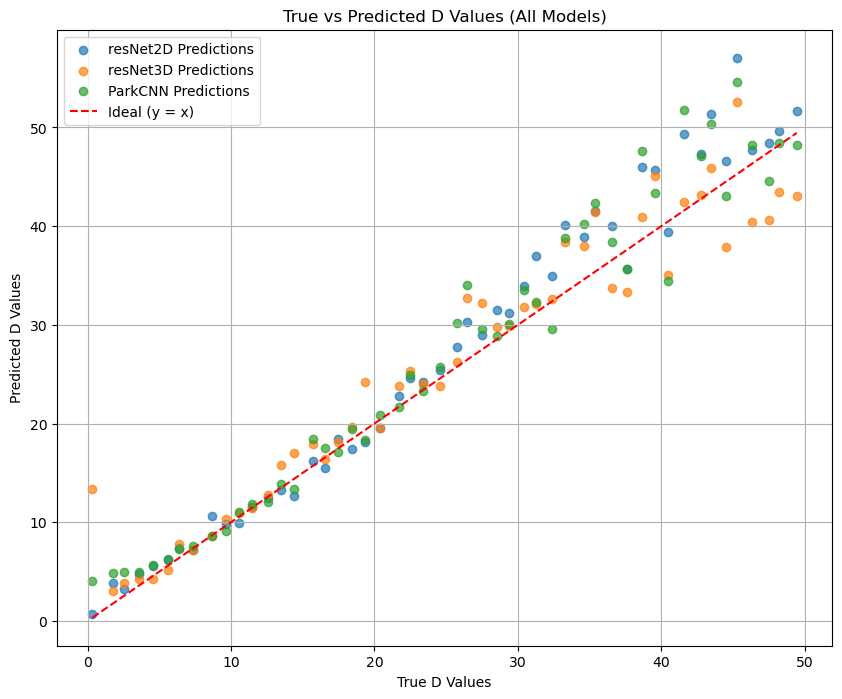

In [9]:
def moving_average(array, window_size=25):
    """
    Computes the moving average of a NumPy array.
    
    Parameters:
        array (np.ndarray): The input array.
        window_size (int): The size of the moving average window (default is 10).
    
    Returns:
        np.ndarray: The smoothed array with the moving average applied.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if window_size > len(array):
        raise ValueError("Window size cannot be larger than the array length.")
    
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')


def average_predictions(predictions, group_size=5):
    """
    Averages predictions in groups of `group_size`.

    Parameters:
    - predictions (torch.Tensor): Input tensor of shape (n * group_size,).
    - group_size (int): The number of elements to average in each group. Default is 5.

    Returns:
    - torch.Tensor: Tensor of shape (n,) where each element is the average of a group of `group_size` elements.
    """
    if predictions.numel() % group_size != 0:
        raise ValueError(f"The input tensor size {predictions.numel()} must be divisible by the group size {group_size}.")
    
    # Reshape to group elements for averaging
    grouped = predictions.view(-1, group_size)
    # Compute the mean along the group dimension
    averaged = grouped.mean(dim=1)
    return averaged


plt.figure(figsize=(10, 6))
for model_name, losses in val_loss_histories.items():
    stop = 200
    plt.plot(range(0, totalEpochs), moving_average(np.clip(losses,0,1000000)), label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss on validation set per Iteration for Each Model')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))

# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    model_preds_gouped = average_predictions(model_preds, group_size=val_im_per_index)
    # Ensure predictions and true values are on the same device and flattened
    model_preds_gouped_array = model_preds_gouped.view(-1).cpu().numpy()  # Convert to numpy for plotting


    # Scatter plot for the current model
    plt.scatter(valDs_array, model_preds_gouped_array, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [10]:
criterion = nn.MSELoss()
coarseDs = np.clip(compute_coarseD_for_batch(val_images, dt)/40,0,60)
coarseD_tensor = torch.tensor(coarseDs, dtype=torch.float32, device=device) 
coarseD_tensor_grouped = average_predictions(coarseD_tensor,group_size=val_im_per_index)
lossCoarseD = criterion(coarseD_tensor, valDs)  # Loss for coarseD predictions

Trajectory D Loss: 24.215360641479492
Model: resNet2D Loss without rotation: 35.296356201171875 Loss with rotation 32.198150634765625
Model: resNet3D Loss without rotation: 44.450225830078125 Loss with rotation 45.033477783203125
Model: ParkCNN Loss without rotation: 39.0391845703125 Loss with rotation 35.993309020996094


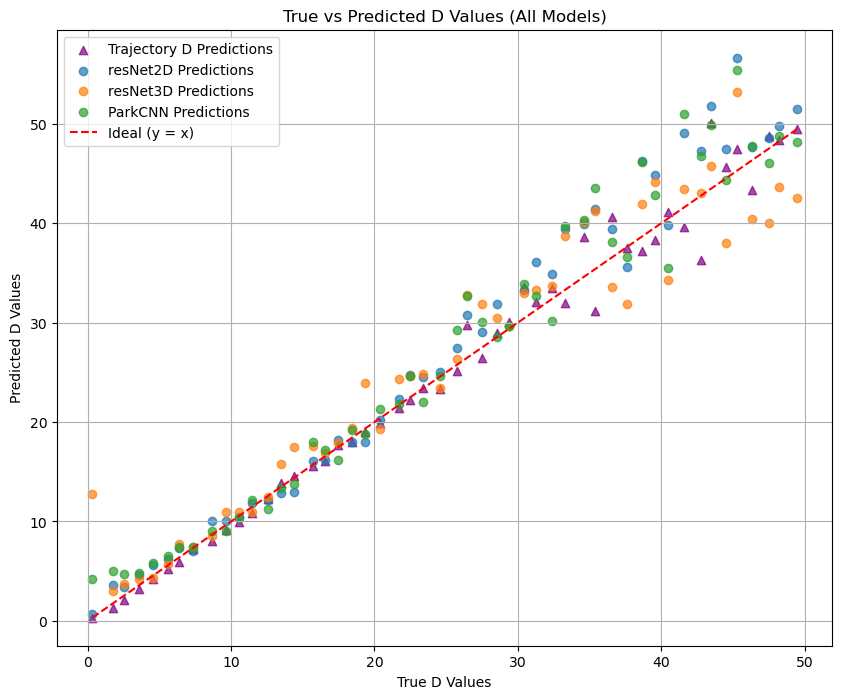

In [12]:
# Initialize a vector to store the average predictions across all models
#average_predictions = torch.zeros_like(valDs_tensor, dtype=torch.float32, device=device)
#average_predictionsRot = torch.zeros_like(valDs_tensor, dtype=torch.float32, device=device)
# Count the number of models contributing to the average
model_count = 0
plt.figure(figsize=(10, 8))

coarseD_array = coarseD_tensor_grouped.view(-1).cpu().numpy()  # Convert to numpy for plotting
plt.scatter(valDs_array, coarseD_array, color='purple', alpha=0.7, label='Trajectory D Predictions', marker='^')
print("Trajectory D Loss:", lossCoarseD.item())


# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    criterion = params["criterion"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    model_predsRot, individualPreds = predict_with_rotations(model, val_images, device)

    # Add predictions to the average vector
    #average_predictions += model_preds
    #average_predictionsRot += model_predsRot
    model_count += 1

    # Compute losses
    loss = criterion(model_preds, valDs)
    lossRot = criterion(model_predsRot, valDs)

    # average predictions for loss
    model_preds = average_predictions(model_preds)
    model_predsRot= average_predictions(model_predsRot)

    

    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    model_predsRot = model_predsRot.view(-1).cpu().numpy()  # Convert to numpy for plotting
    # Scatter plot for the current model
    print("Model:", name, "Loss without rotation:", loss.item(), "Loss with rotation", lossRot.item())
        
    #plt.scatter(valDs_array, model_preds, alpha=0.7, label=f'{name} Predictions')

    plt.scatter(valDs_array, model_predsRot, alpha=0.7, label=f'{name} Predictions')

"""
# Calculate the average predictions
average_predictions /= model_count
average_predictionsRot /= model_count

loss = criterion(average_predictions, valDs)
lossRot = criterion(average_predictionsRot, valDs)

print("Model:", "Average", "Loss without rotation:", loss.item(), "Loss with rotation", lossRot.item())

# Convert average predictions to numpy for plotting
average_predictions_np = average_predictions.view(-1).cpu().numpy()
average_predictions_npRot = average_predictionsRot.view(-1).cpu().numpy()

# Scatter plot for the average predictions
plt.scatter(valDs_array, average_predictions_np, color='orange', alpha=0.9, label='Average Predictions', marker='x')
plt.scatter(valDs_array, average_predictions_npRot, color='yellow', alpha=0.9, label='Average Predictions', marker='x')
"""

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


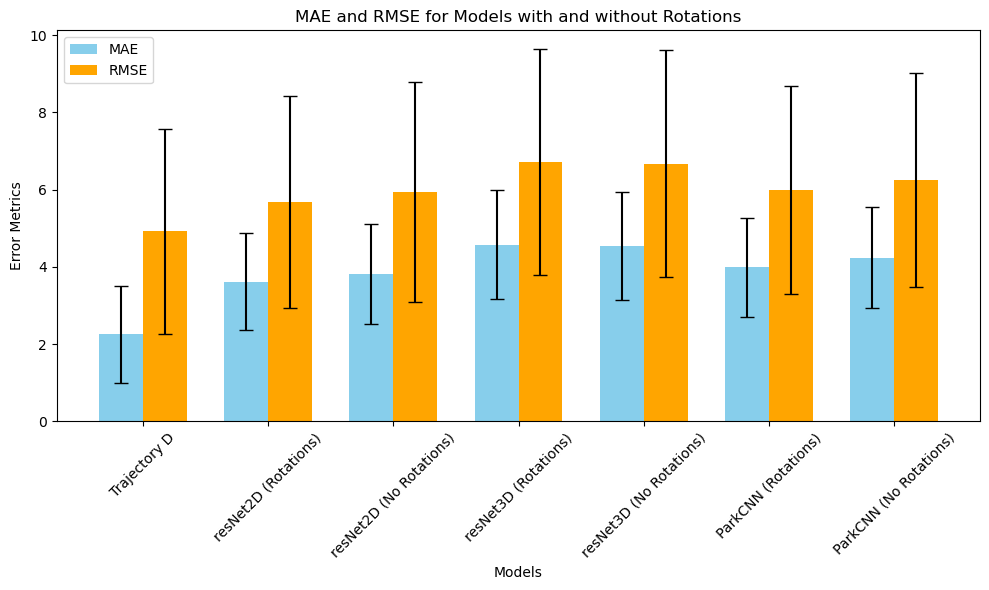

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize storage for results
mae_values = []
rmse_values = []
mae_errors = []
rmse_errors = []
labels = ["Trajectory D"]

div_factor = 3.5

# Compute MAE and RMSE for coarse D (no rotation)
mae_coarse = torch.mean(torch.abs(coarseD_tensor - valDs)).item()
rmse_coarse = torch.sqrt(criterion(coarseD_tensor, valDs)).item()
mae_std_coarse = torch.std(torch.abs(coarseD_tensor - valDs)).item() / div_factor
rmse_std_coarse = torch.std((coarseD_tensor - valDs) ** 2).sqrt().item() / div_factor

# Store coarse D metrics (no rotation)
mae_values.append(mae_coarse)
rmse_values.append(rmse_coarse)
mae_errors.append(mae_std_coarse)
rmse_errors.append(rmse_std_coarse)

# Compute MAE and RMSE for each model
for name, params in models_params.items():
    model = params["loaded_model"]
    criterion = params["criterion"]

    # Predict with rotations
    model_preds_rot, individualPreds_rot = predict_with_rotations(model, val_images, device)
    model_preds_grouped_rot = average_predictions(model_preds_rot, group_size=val_im_per_index)

    # Predict without rotations
    model_preds_no_rot = predict_diffusion_coefficients(model, val_images, device)  # Assuming model can directly predict
    model_preds_grouped_no_rot = average_predictions(model_preds_no_rot, group_size=val_im_per_index)

    # Calculate MAE and RMSE with rotations
    mae_model_rot = torch.mean(torch.abs(model_preds_rot - valDs)).item()
    rmse_model_rot = torch.sqrt(criterion(model_preds_rot, valDs)).item()
    mae_std_model_rot = torch.std(torch.abs(model_preds_rot - valDs)).item() / div_factor
    rmse_std_model_rot = torch.std((model_preds_rot - valDs) ** 2).sqrt().item() / div_factor

    # Calculate MAE and RMSE without rotations
    mae_model_no_rot = torch.mean(torch.abs(model_preds_no_rot - valDs)).item()
    rmse_model_no_rot = torch.sqrt(criterion(model_preds_no_rot, valDs)).item()
    mae_std_model_no_rot = torch.std(torch.abs(model_preds_no_rot - valDs)).item() / div_factor
    rmse_std_model_no_rot = torch.std((model_preds_no_rot - valDs) ** 2).sqrt().item() / div_factor

    # Store metrics with rotation
    mae_values.append(mae_model_rot)
    rmse_values.append(rmse_model_rot)
    mae_errors.append(mae_std_model_rot)
    rmse_errors.append(rmse_std_model_rot)
    labels.append(f"{name} (Rotations)")

    # Store metrics without rotation
    mae_values.append(mae_model_no_rot)
    rmse_values.append(rmse_model_no_rot)
    mae_errors.append(mae_std_model_no_rot)
    rmse_errors.append(rmse_std_model_no_rot)
    labels.append(f"{name} (No Rotations)")

# Plotting
x = np.arange(len(labels))  # X-axis positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for MAE and RMSE
bar1 = ax.bar(x - width / 2, mae_values, width, yerr=mae_errors, label='MAE', capsize=5, color='skyblue')
bar2 = ax.bar(x + width / 2, rmse_values, width, yerr=rmse_errors, label='RMSE', capsize=5, color='orange')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Error Metrics')
ax.set_title('MAE and RMSE for Models with and without Rotations')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


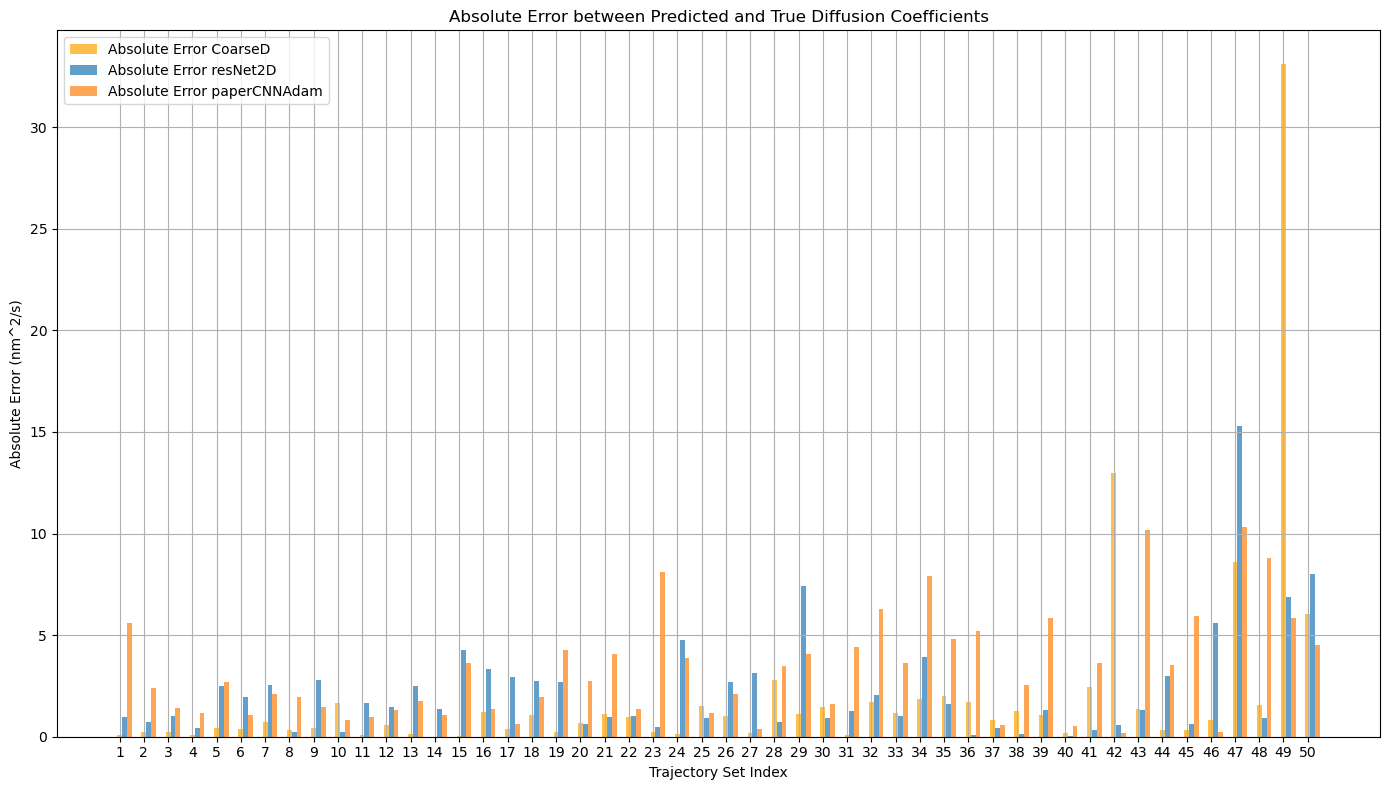

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Absolute error for coarseD
absolute_error_coarseD = np.abs(coarseD_array - valDs_array)

# Number of trajectory sets
num_trajectories = len(valDs_array)

# Define bar width and positions
bar_width = 0.2
x_indices = np.arange(1, num_trajectories + 1)  # Trajectory indices
offset = 0  # Offset for each bar group

# Initialize the figure
plt.figure(figsize=(14, 8))

# Plot absolute error for coarseD
plt.bar(
    x_indices + offset,
    absolute_error_coarseD,
    width=bar_width,
    label="Absolute Error CoarseD",
    alpha=0.7,
    color='orange'
)
offset += bar_width  # Update offset for the next group

# Iterate over all models to plot absolute errors
for name, params in models_params.items():
    # Predictions from the model
    model = params["loaded_model"]
    model_predsRot, individualPreds = predict_with_rotations(model, val_images, device)
    model_predsRot = model_predsRot.view(-1).cpu().numpy()  # Convert to numpy for plotting

    # Calculate absolute error for the model
    absolute_error_model = np.abs(model_predsRot - valDs_array)

    # Plot the bar for the model
    plt.bar(
        x_indices + offset,
        absolute_error_model,
        width=bar_width,
        label=f"Absolute Error {name}",
        alpha=0.7
    )
    offset += bar_width  # Update offset for the next group

# Add labels, title, and legend
plt.xlabel("Trajectory Set Index")
plt.ylabel("Absolute Error (nm^2/s)")
plt.title("Absolute Error between Predicted and True Diffusion Coefficients")
plt.legend()
plt.grid(True)

# Adjust x-axis ticks to center bar groups
plt.xticks(x_indices + (offset - bar_width) / 2 - bar_width, x_indices)

# Show the plot
plt.tight_layout()
plt.show()


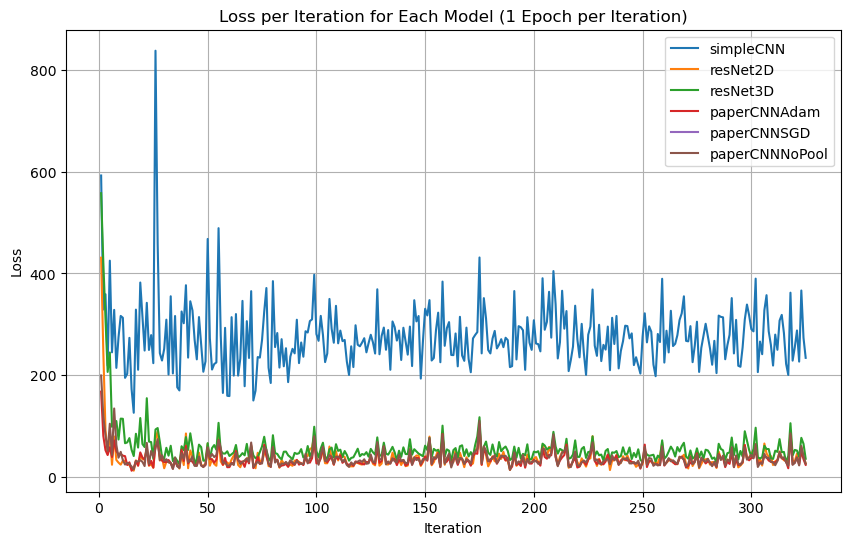

In [98]:

plt.figure(figsize=(10, 6))
for model_name, losses in tr_loss_histories.items():
    plt.plot(range(1, totalEpochs + 1), losses, label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration for Each Model (1 Epoch per Iteration)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# saves all used models 
for name, params in models_params.items():
    model = params["loaded_model"]
    filename = "w_"+name+".pth"
    save_model_weights(model,filename)

Model weights saved to w_resNet2D.pth
Model weights saved to w_resNet3D.pth
Model weights saved to w_ParkCNN.pth


In [27]:
# Save validation Loss and epochs
np.save("allDs.npy",allGeneratedDs)

for model_name, losses in val_loss_histories.items():
    filename = "l_"+model_name+".npy"
    np.save(filename,losses)

Image loaded from refImageSmall.npy
Real D value for image refImageSmall of model: simpleCNN : 1.9350. Model estimated value: 9.9311
Real D value for image refImageSmall of model: resNet : 1.9350. Model estimated value: 3.5535
Real D value for image refImageSmall of model: paperCNNAdam : 1.9350. Model estimated value: 1.8010
Real D value for image refImageSmall of model: paperCNNSGD : 1.9350. Model estimated value: 10.0318


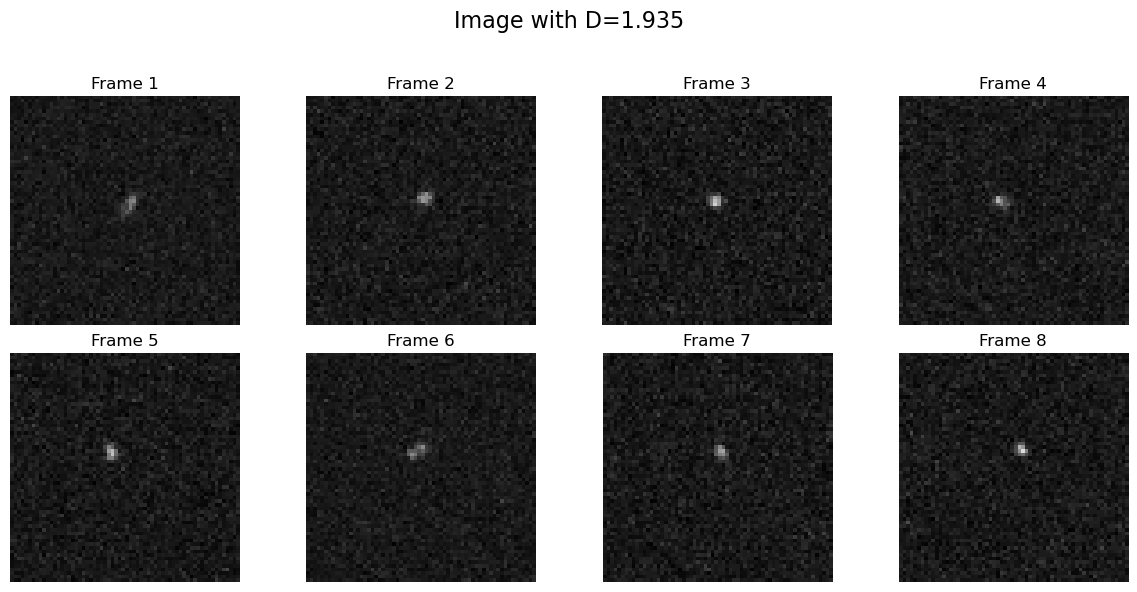

Image loaded from refImage.npy
Real D value for image refImage of model: simpleCNN : 13.8750. Model estimated value: 9.9311
Real D value for image refImage of model: resNet : 13.8750. Model estimated value: 9.6482
Real D value for image refImage of model: paperCNNAdam : 13.8750. Model estimated value: 14.2315
Real D value for image refImage of model: paperCNNSGD : 13.8750. Model estimated value: 10.0318


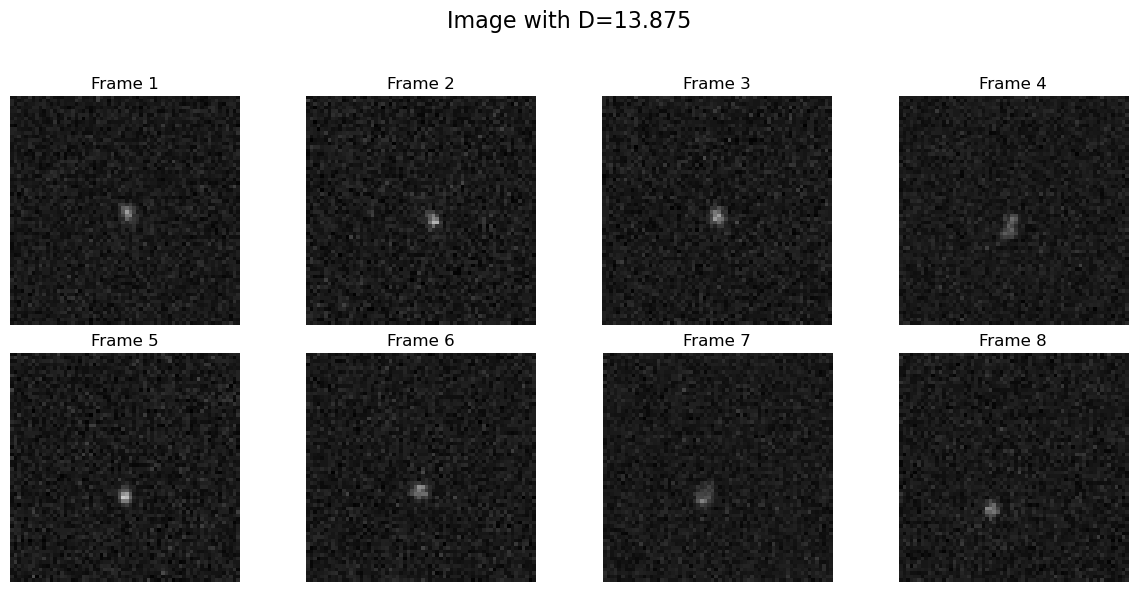

Image loaded from refImageBig.npy
Real D value for image refImageBig of model: simpleCNN : 26.0920. Model estimated value: 9.9311
Real D value for image refImageBig of model: resNet : 26.0920. Model estimated value: 35.0272
Real D value for image refImageBig of model: paperCNNAdam : 26.0920. Model estimated value: 22.5965
Real D value for image refImageBig of model: paperCNNSGD : 26.0920. Model estimated value: 10.0318


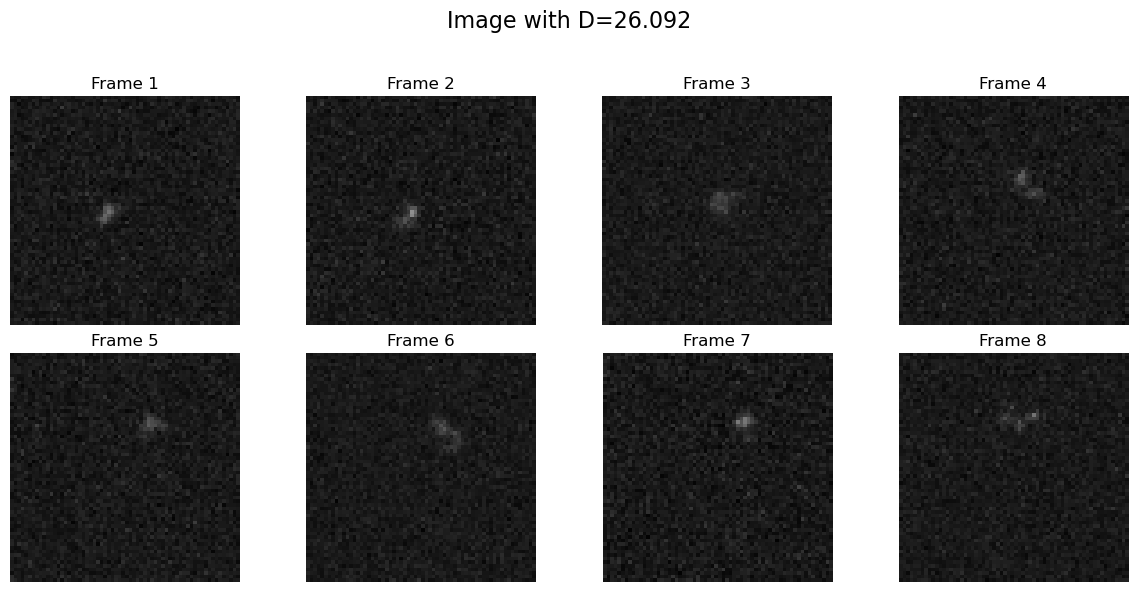

In [77]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImageBig.npy") 


# We created 3 reference images, with different D values, to observe what our algorithm predicts
dict = {"refImageSmall": 1.935, "refImage": 13.875, "refImageBig": 26.092}

for iname, estD in dict.items():
    im = load_image(iname + ".npy")
    for mname, params in models_params.items():
        model = params["loaded_model"]

        modelEstimation = predict_diffusion_coefficients(model, im ,device)
        print(f"Real D value for image {iname} of model: {mname} : {estD:.4f}. Model estimated value: {modelEstimation:.4f}")

    plot_image_frames(im,f"Image with D={estD}")


In [ ]:
# run this code to generate new 50 reference images that will be used to compute the validation loss at each iteration
"""
parts = 10000
trajectories = brownian_motion(parts,nframes,nposframe,500,dt,False)
time_range = np.arange(nframes * nposframe) * dt / nposframe

nIm = 50
val_im_per_index = 5

#trajsToSave = np.zeros((nIm,val_im_per_index,nframes*nposframe,2))
#saved = np.zeros(nIm, dtype=int)

print(saved)
for p in range(parts):
    traj = trajectories[p,:]
    msd = mean_square_displacement(traj)
    estimD = estimateDfromMSD(msd,time_range)


    index = int(estimD/1000)
    if(index < nIm and saved[index] < val_im_per_index):
        indexToSave = saved[index]
        trajsToSave[index,indexToSave,...] = traj
        saved[index] = indexToSave+1

print(saved)
np.save('validation_trajectories.npy',trajsToSave)"""

[0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]
